In [1]:
import os
import sys
import random
import math
import json
import yaml
import joblib
from ast import literal_eval

import torch
import pydantic
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import dgl

In [2]:
image_embed_dict = joblib.load('../zillow_data/image_embed.joblib')
keyword_embed_dict = {}
scene_embed_dict = {}

keyword_embed_dictlist = joblib.load('../zillow_data/keyword_embed.joblib')
for dict in tqdm(keyword_embed_dictlist, desc='converting list to dict'):
    dict_key = list(dict.keys())[0]
    keyword_embed_dict[dict_key] = dict[dict_key]

scene_embed_dictlist = joblib.load('../zillow_data/scene_embed.joblib')
for dict in tqdm(scene_embed_dictlist, desc='converting list to dict'):
    dict_key = list(dict.keys())[0]
    scene_embed_dict[dict_key] = dict[dict_key]

modal_dicts = {
    'images': image_embed_dict,
    'keywords': keyword_embed_dict,
    #'scenes': scene_embed_dict
}

converting list to dict: 100%|██████████| 18/18 [00:00<00:00, 599186.29it/s]


In [3]:
for modal in modal_dicts:
    print(f'Unique {modal} count: {len(list(modal_dicts[modal].keys()))}')

Unique images count: 82720
Unique keywords count: 1542


In [4]:
node_links = pd.read_csv('../zillow_data/NYU_photoboard_file.csv')

# convert string object of image_keyword_hash column back to a list of keyword hashes
node_links['image_keyword_hash'] = node_links['image_keyword_hash'].apply(lambda x: literal_eval(x))
node_links = node_links.rename(columns={'url_hash': 'image_hash', 'image_keyword_hash': 'keyword_hash'})

print('Total rows:', len(node_links))

node_links_keywords_only = node_links[node_links['keyword_hash'].apply(lambda x: x!=[])]
print('Pct of images with at least one keyword:', len(node_links_keywords_only) / len(node_links))
node_links.head()


Total rows: 130065
Pct of images with at least one keyword: 0.2462076653980702


,scene_hash,keyword_hash,image_hash,propertyIdhash
0,67e69903823c5a541b29be07e784b7e6,[],8f1c8d0b5b7cc98231cdea9f923d928e,a3d2de7675556553a5f08e4c88d2c228
1,60825cdcaad5cba560a6f63c895e1f3b,"[851112d8c835d58c497101d9886a1348, b10a8c0bede...",f2d2571c7b9a1e124b188f84222be032,6b693c1082a8f8b747d0db60d179b7b2
2,624109635107c411520779cf9c82ad65,[],3feadc281c74873a6e55a4ab83ebd623,c871527ccd30371d69d21faa47008f12
3,624109635107c411520779cf9c82ad65,[],71906fef662e966b21afa3d53b92decd,c871527ccd30371d69d21faa47008f12
4,624109635107c411520779cf9c82ad65,[],163c91537b81f3ad637d9ceb771e2e1d,c871527ccd30371d69d21faa47008f12


In [5]:
def get_train_val_test_masks(node_ids):
    idxs = [0, 1, 2]
    idx_masks = np.array(random.choices(idxs, weights = (0.7, 0.15, 0.15), k=len(node_ids)))
    train_val_test_masks = np.zeros((idx_masks.size, idx_masks.max() + 1))
    train_val_test_masks[np.arange(idx_masks.size), idx_masks] = 1
    train_val_test_masks = np.array(train_val_test_masks, dtype=bool)
    
    return train_val_test_masks

def nodes_table(modal, modal_dict):
    node_ids = list(modal_dict.keys())
    nodes = pd.DataFrame({'node_id': list(node_ids)})
    train_val_test_masks = get_train_val_test_masks(node_ids)
    nodes[['train_mask', 'val_mask', 'test_mask']] = train_val_test_masks
    
    tqdm.pandas(desc=f'formatting {modal} node embeddings')
    nodes['feat'] = nodes['node_id'].progress_apply(lambda x: ', '.join([str(y) for y in modal_dict[x].tolist()]))

    return nodes

nodes_table_modals = pd.DataFrame()
for modal in modal_dicts:
    nodes_table_modals = pd.concat([nodes_table_modals, nodes_table(modal, modal_dicts[modal])])

nodes_table_modals = nodes_table_modals.drop_duplicates(subset='node_id')

formatting keywords node embeddings: 100%|██████████| 1542/1542 [00:00<00:00, 4647.63it/s]


In [6]:
nodes_table_modals.head()

,node_id,train_mask,val_mask,test_mask,feat
0,e8ca9e20156cff1b5166093249a1a808,True,False,False,"-0.019534708932042122, -0.008678311482071877, ..."
1,0b4f1031b484ce309932faab718593e5,True,False,False,"-0.020777437835931778, 0.007536700926721096, -..."
2,54ea244b01d4fe7bcfb8910e1b16e2da,True,False,False,"-0.012318197637796402, 0.002343656960874796, 0..."
3,3fde20991fe86c0b28b70c050c2c7d5b,True,False,False,"0.03275497257709503, 0.01234776247292757, -0.0..."
4,d14b527f68e2b30ced4d2ddc9d18ff83,False,True,False,"-0.027265874668955803, -0.010033353231847286, ..."


In [7]:
def edges_table(node_links, src_col, dest_col):
    edges = node_links[[src_col, dest_col]]
    dest_is_list = (edges.applymap(type) == list)[dest_col].iloc[0]
    if dest_is_list == True:
        edges = edges.explode(dest_col)\
                     .dropna(subset=dest_col)\
                     .rename(columns={src_col: 'src_id', dest_col: 'dst_id'})\
                     .reset_index(drop=True)
    
    return edges

edges = edges_table(node_links, 'image_hash', 'keyword_hash')
edges.head()

,src_id,dst_id
0,f2d2571c7b9a1e124b188f84222be032,851112d8c835d58c497101d9886a1348
1,f2d2571c7b9a1e124b188f84222be032,b10a8c0bede9eb4ea771b04db3149f28
2,f2d2571c7b9a1e124b188f84222be032,6160972776d990112e5df1ceb938816c
3,f2d2571c7b9a1e124b188f84222be032,b0fa4a8e9d7f6c1142af3533143a5052
4,f2d2571c7b9a1e124b188f84222be032,4a212f77b521bc754e6681feb46f1bd9


In [36]:
# Get cosine similarity of image vectors and tag vectors
from sklearn import metrics

def get_cosine_sim(vecs, all_vecs, vec_idxs):
    '''
    Given a batch of vectors bxd and a matrix of vectors mxd for comparison, 
    give the cosine similarities between the batch vecs and every vector in all_vecs, which
    is calculated by dot(vecs, all_vecs) / (norm(vecs)*norm(all_vecs)) for vec2s in all_vecs

    Returns bxm-sized array of cosine similarities, where idxs corresponding to input vecs is set to 0
    '''
    cosine_sims = metrics.pairwise.cosine_similarity(vecs, all_vecs)
    cosine_sims[np.arange(vec_idxs.size), vec_idxs] = 0

    return cosine_sims

def get_modal_embeds(modal, modal_dicts):
    '''
    Inputs:
        - modal (str): modality key to access modality's embeddings from modal_dicts
        - modal_dicts (dict): dictionary that is structured as follows:
            modal_dict = {modal: {modality_hash_1: [hash_1_embedding],
                                  modality_hash_2: [hash_2_embedding],
                                  ...}}

    Outputs:
    For a given modality (image or keyword), return: 
        - modal_embeds (np array): all embeddings corresponding for the given modality
        - hash_ids (np array): np array where ith entry is the hash_id of the ith row in modal_embeds
    

    '''
    modal_dict = modal_dicts[modal]
    embed_dim = len(modal_dict[list(modal_dict.keys())[0]])
    modal_embeds = np.empty((len(modal_dict.keys()), embed_dim))
    hash_ids = np.array(['']*len(modal_dict.keys()), dtype=object)

    for i, key in enumerate(modal_dict.keys()):
        modal_embeds[i] = modal_dict[key]
        hash_ids[i] = key

    return modal_embeds, hash_ids

def get_new_edges(modal_embeds, hash_ids, sim_threshold, batch_size=500):
    new_edges = pd.DataFrame(columns=['src_id', 'dst_id'])
    sim_stats = {'avg': [], 'min': [], 'max': []}

    # Iterate from 1 to len(modal_embeds) + 1 b/c 0th index is reserved for placeholder
    for i in tqdm(range(0, len(modal_embeds), batch_size), desc='getting new similarity-based edges'):
        edges_to_add = pd.DataFrame()
        end = min(i+batch_size, len(modal_embeds))

        embeds_batch = modal_embeds[i:end]
        cosine_sims_matrix = get_cosine_sim(embeds_batch, modal_embeds, np.array(range(i,end)))
        
        image_matches = []
        for cosine_sims in cosine_sims_matrix:
            hash_ids_relevant = hash_ids[(cosine_sims>sim_threshold)]
            image_matches.append(hash_ids_relevant.tolist())
        
        edges_to_add['src_id'] = hash_ids[i:end]
        edges_to_add['dst_id'] = image_matches
        
        new_edges = pd.concat([new_edges, edges_to_add])
    
    new_edges = new_edges.explode('dst_id').dropna().drop_duplicates().reset_index(drop=True)

    return new_edges



getting new similarity-based edges: 100%|██████████| 166/166 [01:22<00:00,  2.02it/s]


New edges added at threshold 0.95: 46770056


getting new similarity-based edges: 100%|██████████| 166/166 [01:22<00:00,  2.01it/s]


New edges added at threshold 0.96: 14804198


getting new similarity-based edges: 100%|██████████| 166/166 [01:25<00:00,  1.95it/s]


New edges added at threshold 0.97: 2528134


getting new similarity-based edges: 100%|██████████| 166/166 [01:30<00:00,  1.84it/s]


New edges added at threshold 0.98: 104238


getting new similarity-based edges: 100%|██████████| 166/166 [01:27<00:00,  1.89it/s]

New edges added at threshold 0.99: 876


Text(0, 0.5, 'new_edges_counts')

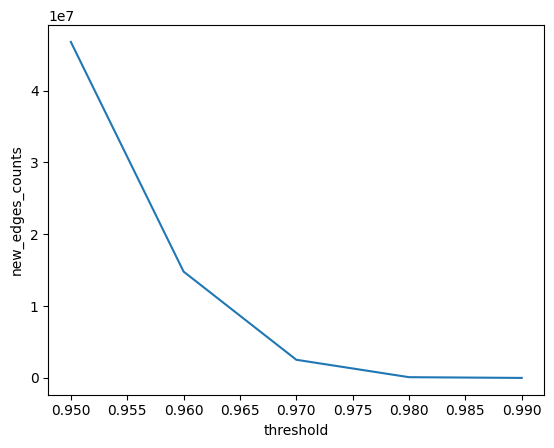

In [44]:
thresholds = [0.95, 0.96, 0.97, 0.98, 0.99]
new_edges_counts = []
modal_embeds, hash_ids = get_modal_embeds('images', modal_dicts)

for threshold in thresholds:
    new_edges = get_new_edges(modal_embeds, hash_ids, sim_threshold=threshold)
    new_edges_counts.append(len(new_edges))
    print(f'New edges added at threshold {threshold}:', len(new_edges))


plt.plot(thresholds, new_edges_counts)
plt.xlabel('threshold')
plt.ylabel('new_edges_counts')


In [9]:
# Store graph csv files

if not os.path.exists('zillow_graph_csv'):
    os.mkdir('zillow_graph_csv')

edges.to_csv('zillow_graph_csv/zillow_edges.csv', index=False)
nodes_table_modals.to_csv('zillow_graph_csv/zillow_nodes.csv', index=False)

g_metadata = {
    'dataset_name': 'zillow_graph',
    'edge_data': [{'file_name': 'zillow_edges.csv'}],
    'node_data': [{'file_name': 'zillow_nodes.csv'}]
}

with open('zillow_graph_csv/meta.yaml', 'w') as file:
    yaml.dump(g_metadata, file)

In [10]:
zillow_graph_dataset = dgl.data.CSVDataset('./zillow_graph_csv')
zillow_graph_dataset

Done saving data into cached files.


Dataset("zillow_graph", num_graphs=1, save_path=./zillow_graph_csv/zillow_graph)

In [11]:
zillow_graph_dataset[0]

Graph(num_nodes=84270, num_edges=226807,
      ndata_schemes={}
      edata_schemes={})

KeyboardInterrupt: 

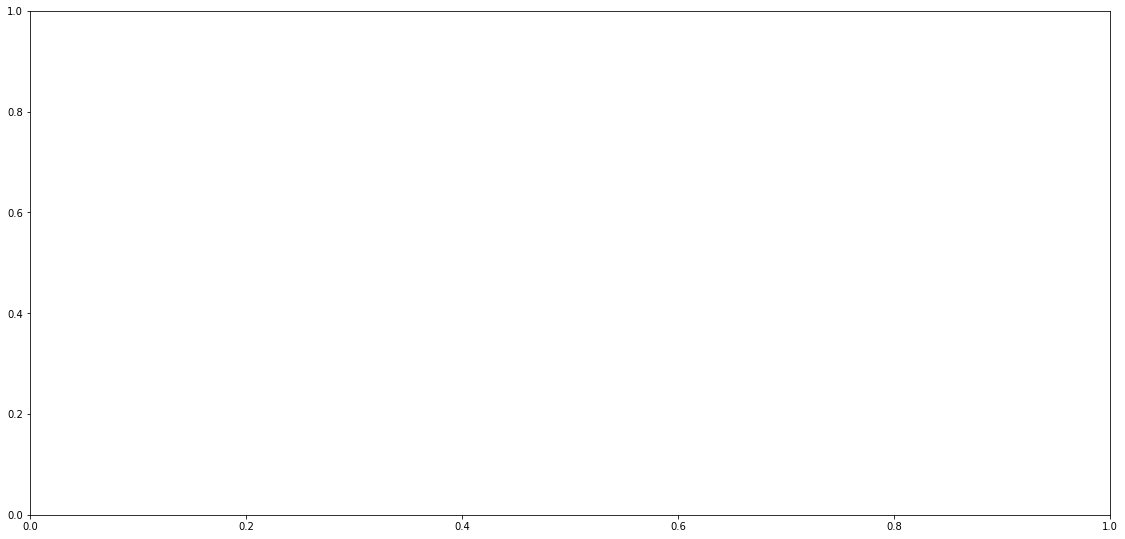

In [12]:
g = zillow_graph_dataset[0]
options = {
    'node_color': 'blue',
    'node_size': 10,
    'width': 1,
}
G = dgl.to_networkx(g)
plt.figure(figsize=[15,7])
nx.draw(G, **options)